Importing Necessary Libraries:

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms

In [100]:
# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),   # Convert image to tensor
    #transforms.Normalize((0.5,), (0.5,))   # Normalize pixel values to range [-1, 1]
])

# Load FashionMNIST training set
train_set = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Load FashionMNIST test set
test_set = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

In [101]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=32,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=32,
    shuffle=True
)

Here we can see the target classes:

In [102]:
# Output labels
print(train_set.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Let's see the number of channels and pixels in each image:

In [103]:
# size of the images
print(train_set[0][0].shape)

torch.Size([1, 28, 28])


Images are in grayscale form, so we have only one channel.

Here we can have a look at the data we are working with:

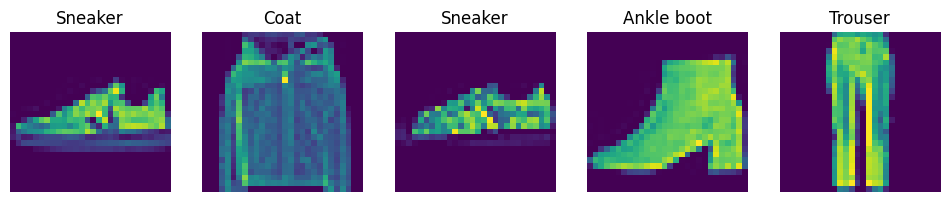

In [104]:
import matplotlib.pyplot as plt
# Get a few random images from the training set
indices = np.random.choice(len(train_set), 5, replace=False)
images = [train_set[i][0] for i in indices]
labels = [train_set[i][1] for i in indices]

# Plot the images with their categories
fig, ax = plt.subplots(1, 5, figsize=(12, 4))
for i in range(5):
    ax[i].imshow(images[i].permute(1, 2, 0).numpy())
    ax[i].set_title(train_set.classes[labels[i]])
    ax[i].axis('off')
plt.show()

In [105]:
# Define the neural network with given parameters : num of hidden layers, num of neurons in each layer
class NeuralNetwork(nn.Module):
    def __init__(self, num_hidden_layers, num_neurons, num_classes, dropout_prob=0.1):
        super(NeuralNetwork, self).__init__()
        self.num_hidden_layers = num_hidden_layers
        self.num_neurons = num_neurons
        self.layers = nn.ModuleList()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.layers.append(nn.Linear(784, num_neurons[0]))
        for i in range(1, num_hidden_layers):
            self.layers.append(nn.Linear(num_neurons[i-1], num_neurons[i]))
            self.layers.append(nn.ReLU())
            self.layers.append(self.dropout)
        self.layers.append(nn.Linear(num_neurons[-1], num_classes))

    def forward(self, x):
        x = x.flatten(start_dim=1)
        for i in range(len(self.layers)):
            x = self.layers[i](x)
        return x

In [106]:
def evaluate(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

In [107]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    train_accs = []
    val_accs = []
    for epoch in range(num_epochs):
        train_loss = 0.0
        train_total = 0
        train_correct = 0
        for i, (images, labels) in enumerate(train_loader):
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update training statistics
            train_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            # Print progress every 100 batches
            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        # Compute train and validation accuracies
        train_acc = train_correct / train_total
        val_acc = evaluate(model, val_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

        # Save train loss and accuracies for plotting
        train_losses.append(train_loss / len(train_loader.dataset))
        train_accs.append(train_acc)
        val_accs.append(val_acc)

    return train_losses, train_accs, val_accs 

In [108]:
# Define the model
model = NeuralNetwork(3, [256, 128, 64], 10)
print(model)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_losses, train_accs, val_accs = train(model, train_loader, test_loader, criterion, optimizer, num_epochs=10)

NeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.1, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
)
Epoch [1/10], Step [100/1875], Loss: 0.7334
Epoch [1/10], Step [200/1875], Loss: 0.5615
Epoch [1/10], Step [300/1875], Loss: 0.6242
Epoch [1/10], Step [400/1875], Loss: 0.4992
Epoch [1/10], Step [500/1875], Loss: 0.3493
Epoch [1/10], Step [600/1875], Loss: 0.7186
Epoch [1/10], Step [700/1875], Loss: 1.1168
Epoch [1/10], Step [800/1875], Loss: 0.3667
Epoch [1/10], Step [900/1875], Loss: 0.4769
Epoch [1/10], Step [1000/1875], Loss: 0.5360
Epoch [1/10], Step [1100/1875], Loss: 0.2986
Epoch [1/10], Step [1200/1875], Loss: 0.4123
Epoch [1/10], Step [1300/1

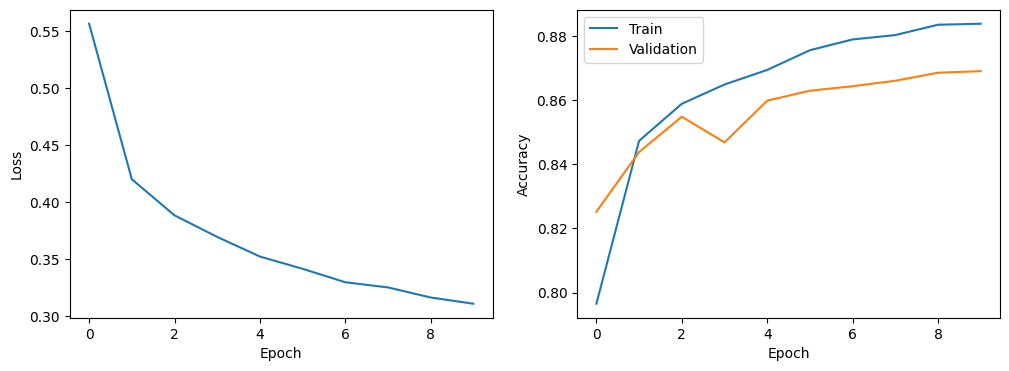

In [109]:
# Plot the training loss and accuracies
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(train_losses)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(train_accs, label='Train')
ax[1].plot(val_accs, label='Validation')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()

Here we can see the predictions of our model and true labels:

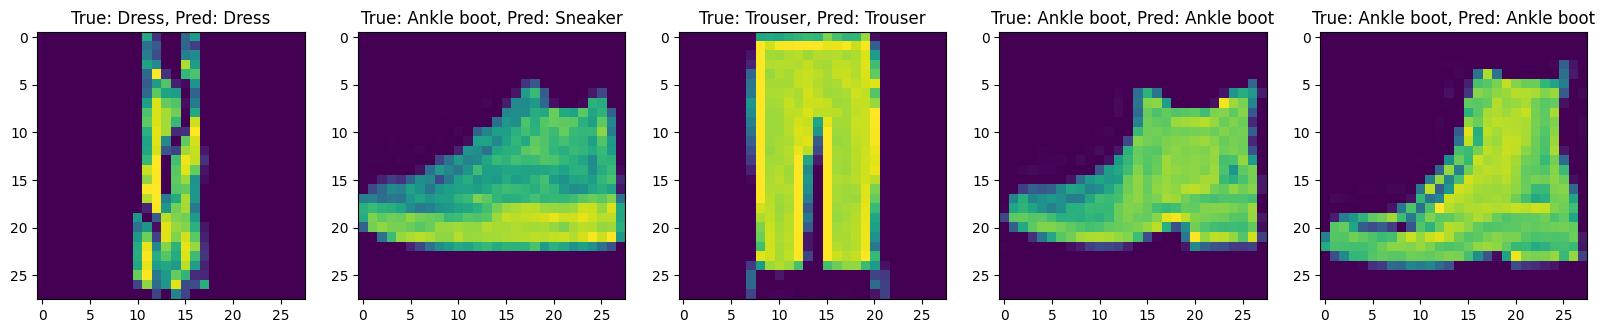

In [110]:
# Set model to evaluation mode
model.eval()

# Get a batch of test data
images, labels = next(iter(test_loader))

# Make predictions
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Convert labels and predictions to numpy arrays and to categorical labels
labels = labels.numpy()
predicted = predicted.numpy()

# Show some predictions and true labels
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    axs[i].imshow(images[i].permute(1, 2, 0).numpy())
    axs[i].set_title(f'True: {test_set.classes[labels[i]]}, Pred: {test_set.classes[predicted[i]]}')
plt.show()